In [1]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-4_c_jwc9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-4_c_jwc9
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
^C
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user


In [2]:
!pip install -q detectron2
!pip install -q torch torchvision

In [3]:
# ✅ Install Detectron2 (For Kaggle)
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.1/index.html

# ✅ Import Libraries
import os
import torch
import detectron2
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data.transforms import (
    RandomFlip, RandomBrightness, RandomSaturation, RandomContrast, ResizeShortestEdge
)

setup_logger()
print("✅ Detectron2 Installed and Ready!")

✅ Detectron2 Installed and Ready!


In [7]:

# ✅ Define Dataset Paths (Change if needed)
TRAIN_JSON = "/kaggle/input/blood-final/merged/jtrain.json"
VALID_JSON =  "/kaggle/input/blood-final/merged/jvalid.json"
TRAIN_IMG_DIR =  "/kaggle/input/blood-final/merged/train"
VALID_IMG_DIR = "/kaggle/input/blood-final/merged/valid"

# ✅ Register COCO Datasets
register_coco_instances("blood_train", {}, TRAIN_JSON, TRAIN_IMG_DIR)
register_coco_instances("blood_valid", {}, VALID_JSON, VALID_IMG_DIR)

# ✅ Retrieve Metadata
train_metadata = MetadataCatalog.get("blood_train")
valid_metadata = MetadataCatalog.get("blood_valid")

# ✅ Augmented Trainer with Data Augmentations
class BloodAugmentedTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            cfg,
            mapper=DatasetMapper(cfg, is_train=True, augmentations=[
                RandomFlip(0.5,horizontal=True),
                RandomBrightness(0.9, 1.1),  # Simulate lighting variations
                RandomSaturation(0.8, 1.2),  # Adjust blood redness intensity
                RandomContrast(0.8, 1.2),  # Enhance visibility of faint blood stains
                ResizeShortestEdge(short_edge_length=(512, 1024), max_size=1333, sample_style="choice")  # Standardize sizes
            ])
        )


print("✅ Dataset Registered & Augmented Trainer Ready!")

✅ Dataset Registered & Augmented Trainer Ready!


In [8]:
# ✅ Configuring Mask R-CNN with ResNet101
from detectron2.config import get_cfg
from detectron2 import model_zoo 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("blood_train",)
cfg.DATASETS.TEST = ("blood_valid",)  # Enable validation evaluation
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 2  # Adjust based on GPU memory
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
cfg.SOLVER.MAX_ITER = 10000  # Total iterations (~8500 images -> 10-12 epochs)
cfg.SOLVER.STEPS = [7000, 9000]  # Learning rate decay steps
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class: Blood
cfg.TEST.EVAL_PERIOD = 500  # Evaluate every 500 iterations

# ✅ Create Trainer & Start Training
cfg.OUTPUT_DIR = "/kaggle/working/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = BloodAugmentedTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/13 21:16:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 229MB/s]                             


[02/13 21:16:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/13 21:16:58 d2.utils.events]:  eta: 1:55:23  iter: 19  total_loss: 2.376  loss_cls: 0.6803  loss_box_reg: 0.8782  loss_mask: 0.6969  loss_rpn_cls: 0.06057  loss_rpn_loc: 0.02162    time: 0.6285  last_time: 0.7059  data_time: 0.0334  last_data_time: 0.0057   lr: 4.9953e-06  max_mem: 4517M
[02/13 21:17:32 d2.utils.events]:  eta: 1:55:09  iter: 39  total_loss: 2.288  loss_cls: 0.6413  loss_box_reg: 0.8882  loss_mask: 0.6937  loss_rpn_cls: 0.06128  loss_rpn_loc: 0.01897    time: 0.5819  last_time: 0.3654  data_time: 0.0057  last_data_time: 0.0012   lr: 9.9902e-06  max_mem: 4517M
[02/13 21:17:45 d2.utils.events]:  eta: 1:55:22  iter: 59  total_loss: 2.467  loss_cls: 0.5754  loss_box_reg: 0.8864  loss_mask: 0.6863  loss_rpn_cls: 0.09541  loss_rpn_loc: 0.02955    time: 0.6105  last_time: 0.7383  data_time: 0.0058  last_data_time: 0.0082   lr: 1.4985e-05  max_mem: 4517M
[02/13 21:17:59 d2.utils.events]:  eta: 1:56:30  iter: 79  total_loss: 2.3  loss_cls: 0.5248  loss_box_reg: 0.8355  loss_

In [9]:
import shutil

shutil.copy("/kaggle/working/output/model_final.pth", "/kaggle/working/mask_rcnn_blood.pth")
print("Model saved as mask_rcnn_blood.pth")

Model saved as mask_rcnn_blood.pth


[02/13 23:56:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/mask_rcnn_blood.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Predictions: {'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 16.6500,  15.7321, 624.9843, 554.8468]], device='cuda:0')), scores: tensor([0.9291], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


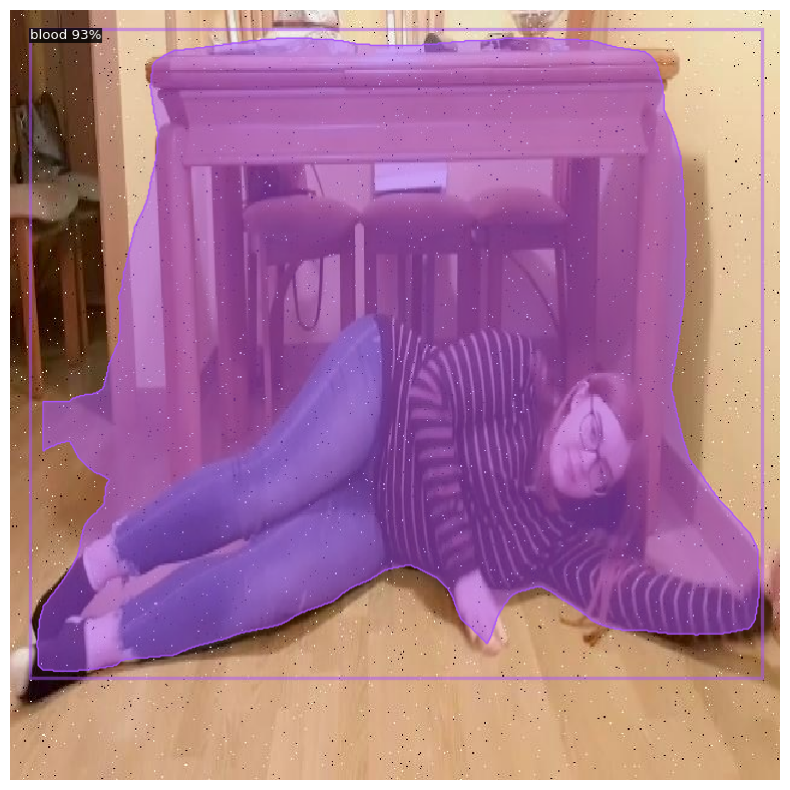

Instance 1 has 235074 pixels.
Total pixels in the image: 409600


In [71]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt
import numpy as np

# ✅ Load trained model
cfg.MODEL.WEIGHTS = "/kaggle/working/mask_rcnn_blood.pth"  # Use the saved model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 # Set confidence threshold
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

predictor = DefaultPredictor(cfg)

# ✅ Load test image
image_path = "/kaggle/input/gendertest/tryacc3.jpg"  # Change to your test image path
image = cv2.imread(image_path)
image=cv2.resize(image,(640,640))
# ✅ Make prediction
outputs = predictor(image)
pred_masks = outputs["instances"].pred_masks.cpu().numpy()
print("Predictions:", outputs)  # Print output for debugging

# ✅ Visualize results with only masks (no bounding boxes)
v = Visualizer(image[:, :, ::-1], 
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
               scale=1.2)

# Draw instance predictions without bounding boxes
# This should draw only the masks without the bounding boxes
v_output = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()

# ✅ Show image with only masks (no bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(v_output)
plt.axis("off")
plt.show()
for idx, mask in enumerate(pred_masks):
    # Count number of non-zero pixels (i.e., part of the object)
    mask_area = np.sum(mask)  # This will count the number of 1s in the mask (the object area)
    print(f"Instance {idx+1} has {mask_area} pixels.")
height, width, _ = image.shape
total_pixels = height * width
print(f"Total pixels in the image: {total_pixels}")

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# ✅ Create COCO Evaluator
evaluator = COCOEvaluator("blood_valid", cfg, False, output_dir=cfg.OUTPUT_DIR)

# ✅ Create Data Loader
val_loader = build_detection_test_loader(cfg, "blood_valid")

# ✅ Run Evaluation
results = inference_on_dataset(trainer.model, val_loader, evaluator)

# ✅ Print Results
print("Evaluation Results:", results)

WARNING [02/13 23:18:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/13 23:18:17 d2.data.datasets.coco]: Loaded 1729 images in COCO format from /kaggle/input/blood-final/merged/jvalid.json
[02/13 23:18:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/13 23:18:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/13 23:18:17 d2.data.common]: Serializing 1729 elements to byte tensors and concatenating them all ...
[02/13 23:18:17 d2.data.common]: Serialized dataset takes 3.35 MiB
[02/13 23:18:17 d2.evaluation.evaluator]: Start inference on 1729 batches
[02/13 23:18:19 d2.evaluation.evaluator]: Inference done 11/1729. Dataloading: 0.0013 s/iter. Inference: 0.1224 s/iter. Eval: 0.0466 s/iter. Total: 0.1703 s/iter.